In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.stats import multivariate_normal

In [2]:
@njit
def determ(u):
    '''
    Deterministic function

    Arguments:
        u -- input vector

    Returns:
        deterministic model output value
    '''
    alpha, beta = u
    return 1.5*alpha + 0.25*(beta-1)**2 + np.cos(np.pi+alpha+beta)

@njit
def func(u):
    '''
    Adds noise to deterministic model

    Arguments:
        u -- input vector

    Returns:
        noisy model output value
    '''
    alpha, beta = u
    return determ(alpha,beta)+np.random.normal(0,0.1)

def prior(u,sigma=0.25):
    '''
    Prior PDF of multivariate normal centered at (0,4)

    Arguments:
        u -- input vector

    Keyword Arguments:
        sigma -- scale of distribution (default: {0.25})

    Returns:
        probability of input vector
    '''
    return multivariate_normal.pdf(u, mean = [0,4], cov = sigma)

@njit
def proposal(u,sigma):
    '''
    Generates a new proposal from normal distribution.

    Arguments:
        u -- input vector
        sigma -- scale of normal distribution

    Returns:
        proposal vector
    '''
    alpha, beta = u
    alpha = alpha + np.random.normal(0,sigma)
    beta = beta + np.random.normal(0,sigma)
    return np.array([alpha, beta])

def likelihood_ratio(u_prop,u,data,sigma=0.1):
    '''
    Calculates the likelihood ratio for a proposal based on the model

    Arguments:
        u_prop -- proposal vector
        u -- current vector
        data -- data vector

    Keyword Arguments:
        sigma -- scale of the observation error (default: {0.1})

    Returns:
        _description_
    '''
    u_prop_sum = np.sum(np.subtract(data,determ(u_prop))**2)
    u_sum = np.sum(np.subtract(data,determ(u))**2)
    return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))

def accept_prob(u_prop,u,data):
    '''
    Calculates the acceptance probability

    Arguments:
        u_prop -- proposal vector
        u -- current vector
        data -- data vector

    Returns:
        acceptance probability
    '''
    ratio = prior(u_prop)/prior(u)
    ratio = ratio * likelihood_ratio(u_prop,u,data)
    return np.min([1,ratio])

def metropolis_hastings(steps,data,sigma=1,u0 = np.array([0,0])):
    '''
    Metropolis Hastings algorithm to sample the posterior distribution

    Arguments:
        steps -- number of MCMC steps
        data -- data vector

    Keyword Arguments:
        sigma -- scale of the proposal distribution (default: {1})
        u0 -- initial vector (default: {np.array([0,0])})

    Returns:
        samples -- array of sample vectors
        probs -- array with acceptance probabilities
    '''
    samples = np.zeros((steps+1,2))
    probs = np.zeros(steps)
    samples[0] = u0

    accepted = 0
    for i in range(steps):
        
        u_prop = proposal(samples[i],sigma)
        probs[i] = accept_prob(u_prop, samples[i],data)

        if probs[i] >= np.random.rand():
            samples[i+1] = u_prop
            accepted += 1
        else:
            samples[i+1] = samples[i]

    print('acceptance rate: ',accepted/steps)
    return samples, probs

# data vector
data = [4.02, 3.97, 4.05, 3.85, 3.94]

In [3]:
samples, probs = metropolis_hastings(101_000,data,sigma=0.13)

/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_42217/4149851037.py:78: RuntimeWarning: overflow encountered in exp
  return np.exp(1/(2*sigma**2) * (-u_prop_sum + u_sum))


acceptance rate:  0.28011881188118815


In [4]:
# scale plots nicely to data
min_alpha = np.min(samples[:,0])
max_alpha = np.max(samples[:,0])
min_beta = np.min(samples[:,1])
max_beta = np.max(samples[:,1])
pad_alpha = 8-(max_alpha-min_alpha)
pad_beta = 8-(max_beta-min_beta)

N = 100
a = np.linspace(min_alpha-pad_alpha,max_alpha+pad_alpha,N)
b = np.linspace(min_beta-pad_beta,max_beta+pad_beta,N)
deterministic_out = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        deterministic_out[i,j] = determ(np.array([a[i],b[j]]))

A,B = np.meshgrid(a,b)

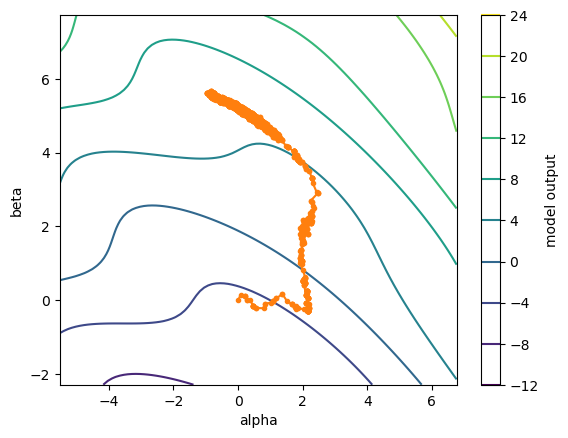

In [5]:
# plot path for first 5000 steps
plt.contour(A,B,deterministic_out)
plt.colorbar(label = 'model output')
plt.plot(samples[:5000,0],samples[:5000,1], c='C1', marker ='.')
plt.ylabel('beta')
plt.xlabel('alpha')
plt.savefig('MCMC_path_contour.png', dpi=300)

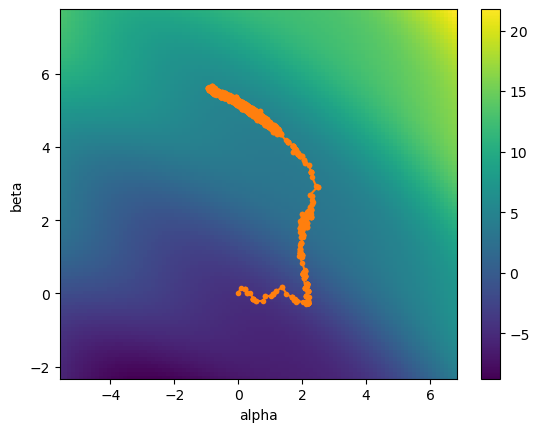

In [6]:
# plot path for first 5000 steps
plt.pcolor(A,B,deterministic_out)
plt.plot(samples[:5000,0],samples[:5000,1], c='C1', marker ='.')
plt.colorbar()
plt.ylabel('beta')
plt.xlabel('alpha')
plt.savefig('MCMC_path_smooth.png', dpi=300)

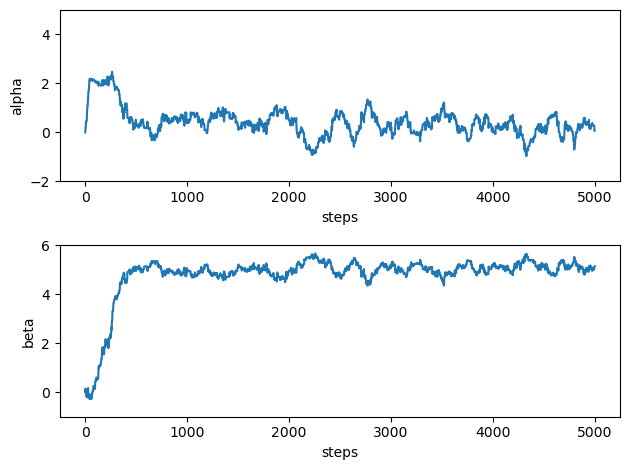

In [7]:
# plot convergence for first 5000 steps
fig, axs = plt.subplots(2,1)
axs[0].plot(samples[:5000,0])
axs[0].set_ylim([-2,5])
axs[0].set_ylabel('alpha')
axs[0].set_xlabel('steps')

axs[1].plot(samples[:5000,1])
axs[1].set_ylim([-1,6])
axs[1].set_ylabel('beta')
axs[1].set_xlabel('steps')
plt.tight_layout()
plt.savefig('convergence.png', dpi=300)

In [8]:
# calulate the deterministic model output for the samples
det_samp = np.zeros(len(samples))
for i, sample in enumerate(samples):
    det_samp[i] = determ(sample)

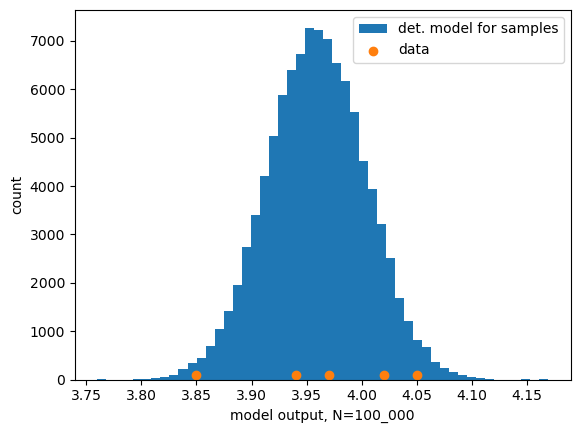

In [9]:
# compare the deterministic model output for the samples to the data
plt.hist(det_samp[1000:], bins=50, label = 'det. model for samples')
plt.scatter(data, 100*np.ones_like(data),c='C1', label = 'data')
plt.xlabel('model output, N=100_000')
plt.ylabel('count')
plt.legend()
plt.savefig('data_vs_sampled_model.png', dpi=300)

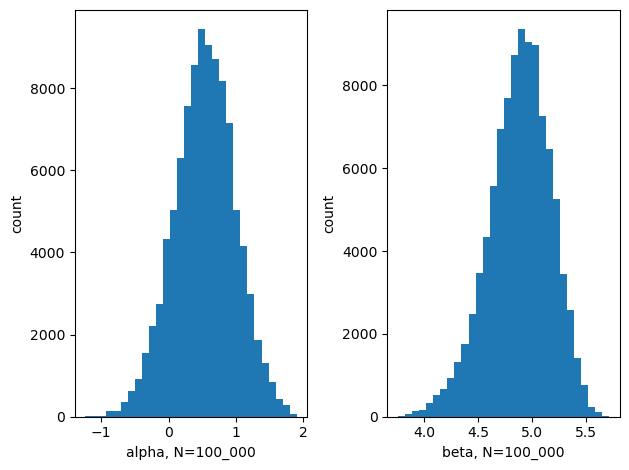

In [10]:
# plot the marignal distributions of alpha and beta
fig, axs = plt.subplots(1,2)
axs[0].hist(samples[1000:,0],bins=30)
axs[0].set_xlabel('alpha, N=100_000')
axs[0].set_ylabel('count')

axs[1].hist(samples[1000:,1],bins=30)
axs[1].set_xlabel('beta, N=100_000')
axs[1].set_ylabel('count')
plt.tight_layout()
plt.savefig('marginals.png', dpi=300)

In [11]:
# covariance matrix for alpha and beta
np.cov(samples[1000:].T)

array([[ 0.20355731, -0.12706547],
       [-0.12706547,  0.08184369]])